<a href="https://colab.research.google.com/github/NahianAlindo/gait_recognition/blob/main/CNN_without_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Accelerator status

In [1]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import os
try:
    tpu = False     
    assert torch.cuda.is_available()
    gpu = True
    ! nvidia-smi
except:
    try:
        tpu = True
        gpu = False
        if 'COLAB_TPU_ADDR' not in os.environ:
            print('ERROR: Not connected to a TPU runtime')
        else:
            tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
            print ('TPU address is', tpu_address)
        import tensorflow as tf
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print('==========MEM=============')
        ! cat /proc/meminfo
        print("============CPU============")
        ! cat /proc/cpuinfo
        from psutil import *
        cpu_count()
        cpu_stats()
        
print("============STORAGE============")
! df -h

Thu Feb 17 10:01:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import *
virtual_memory()

svmem(total=13622190080, available=11850899456, percent=13.0, used=1553989632, free=7587672064, active=1902772224, inactive=3804254208, buffers=138235904, cached=4342292480, shared=1228800, slab=179834880)

In [5]:
! pip install keras_tuner
! pip install tensorflow-addons

     |████████████████████████████████| 98 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


# Import Libraries

In [6]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow_addons.optimizers import CyclicalLearningRate
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import *
import seaborn as sns
import tensorflow.keras.metrics as metrics
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions for loading dataset, plots and performance

In [7]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [8]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

In [9]:
def plot_performance(X_train, train_label, history):
    plt.plot(history.history['accuracy'])
    try:
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    except:
        pass
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

    plt.plot(history.history['loss'])
    try:
        plt.plot(history.history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

In [10]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [11]:
activation = ['tanh','relu','sigmoid','softplus','softsign','selu','elu','exponential','softmax'] # None
activs = ['tanh','relu','sigmoid','softplus','softsign','selu','elu','exponential','softmax']
bool_ = [True,False]
n_filters = [32,64,128,256,512]
inits = ['glorot_uniform','random_normal','random_uniform','truncated_normal','zeros','ones','glorot_normal','he_normal','he_uniform','orthogonal','constant','variance_scaling']
regularizers = ['l1','l2','l1_l2'] # None
dropouts = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
k_size = [3,5,7,8,9]
strides = [1,2,5]
pad = ['same','valid']
seed = 42

# Tuner

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = Bidirectional(LSTM(hp.Choice('Bi-LSTM_1',values=n_filters),'tanh','sigmoid',True,hp.Choice('k_init_L',values=inits)))(x)
    x = Dropout(hp.Choice(name='Dropout',values=dropouts),seed=42)(x)
    y = Permute((2,1))(ip)
    
    y = Conv1D(hp.Choice('cn1_filter',values=n_filters),hp.Choice(
        name='cn1_k_size',values=k_size),hp.Choice(name='cn2_s',values=strides),hp.Choice(name='cn1_p',values = pad),
        'channels_last',1,1,None,hp.Choice(name='cn1_use_b',values=bool_),hp.Choice('cn1_k_init',values=inits),
        hp.Choice('cn1_b_init',values=inits))(y)
    y = BatchNormalization(-1,0.99,0.001,hp.Choice('bn1_ctr',values=bool_),hp.Choice(
        'bn1_scl',values=bool_),hp.Choice('bn1_beta_init',values=inits),hp.Choice('bn1_gama_init',values=inits),
        hp.Choice('bn1_mvmean_init',values=inits),hp.Choice('bn1_mvvar_init',values=inits),
        hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
    y = Activation(hp.Choice('activ_1',values=activation))(y)
    y = squeeze_excite_block(y)

    y = Conv1D(hp.Choice('cn2_filter',values=n_filters),hp.Choice(
        name='cn2_k_size',values=k_size),hp.Choice(name='cn3_s',values=strides),
        hp.Choice(name='cn2_p',values=pad),'channels_last',1,1,None,hp.Choice(name='cn2_use_b',values=bool_),
        hp.Choice('cn2_k_init',values=inits),hp.Choice('cn2_b_init',values=inits))(y)
    y = BatchNormalization(-1,0.99,0.001,hp.Choice('bn2_ctr',values=bool_),hp.Choice(
        'bn2_scl',values=bool_),hp.Choice('bn2_beta_init',values=inits),hp.Choice('bn2_gama_init',values=inits),
        hp.Choice('bn2_mvmean_init',values=inits),hp.Choice('bn2_mvvar_init',values=inits),
        hp.Choice('bn2_beta_reg',values=regularizers),hp.Choice('bn2_gama_reg',values=regularizers))(y)
    y = Activation(hp.Choice('activ_2',values=activation))(y)
    y = squeeze_excite_block(y)

    y = Conv1D(hp.Choice('cn3_filter',values=n_filters),hp.Choice(
        name='cn3_k_size',values=k_size),hp.Choice(name='cn1_s',values=strides),
        hp.Choice(name='cn3_p',values=pad),'channels_last',1,1,None,hp.Choice(name='cn3_use_b',values=bool_),
        hp.Choice('cn3_k_init',values=inits),hp.Choice('cn3_b_init',values=inits))(y)
    y = BatchNormalization(-1,0.99,0.001,hp.Choice('bn3_ctr',values=bool_),hp.Choice(
        'bn3_scl',values=bool_),hp.Choice('bn3_beta_init',values=inits),hp.Choice('bn3_gama_init',values=inits),
        hp.Choice('bn3_mvmean_init',values=inits),hp.Choice('bn3_mvvar_init',values=inits),
        hp.Choice('bn3_beta_reg',values=regularizers),hp.Choice('bn3_gama_reg',values=regularizers))(y)
    y = Activation(hp.Choice('activ_3',values=activation))(y)
    y = GlobalAveragePooling1D()(y)

    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=cyclical_learning_rate)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [16]:
# PRE
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    # x = Masking()(ip)
    # x = Bidirectional(LSTM(units=8))(x)
    # x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    # y = squeeze_excite_block(y)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    # y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    # y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    # x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(y)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

dataset 1 identity

In [17]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_1 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 32)           1760      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 128, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 512)          147968    
                                                           

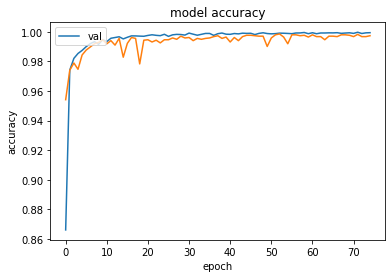

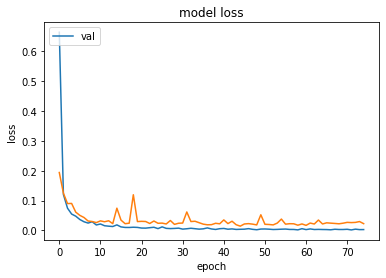

In [18]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [19]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 2s 16ms/step - loss: 0.5444 - accuracy: 0.9463 - auc: 0.9816 - recall: 0.9457
Test loss:0.5444061160087585
Test accuracy:0.946256697177887
Test Recall: 0.9457219243049622
Test AUC: 0.9815859794616699


dataset 2 identity

In [20]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_2 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 128, 32)           1760      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 128, 32)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 128, 512)          147968    
                                                           

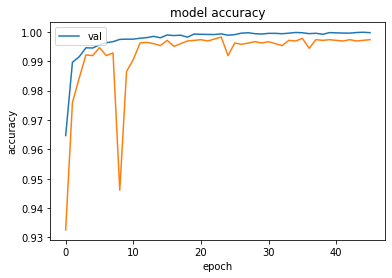

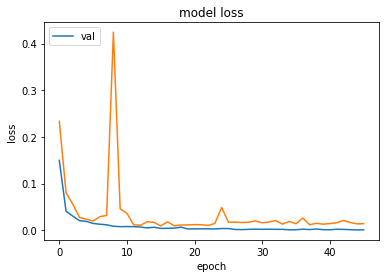

In [21]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [22]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 2s 16ms/step - loss: 0.1687 - accuracy: 0.9757 - auc: 0.9914 - recall: 0.9743
Test loss:0.16872155666351318
Test accuracy:0.9756888151168823
Test Recall: 0.9742706418037415
Test AUC: 0.9914333820343018


dataset ou identity

In [23]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_3 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 128, 32)           1760      
                                                                 
 batch_normalization_9 (Batc  (None, 128, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 128, 32)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 128, 512)          147968    
                      

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_4 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 128, 32)           1760      
                                                                 
 batch_normalization_12 (Bat  (None, 128, 32)          128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 128, 32)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 128, 512)          147968    
                                                           

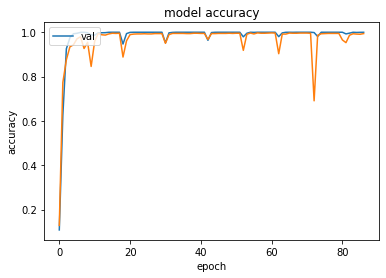

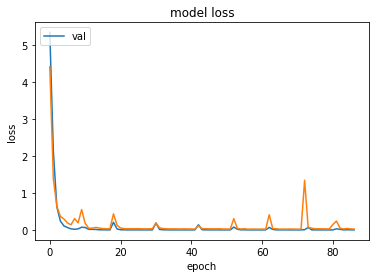

In [24]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [25]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 18ms/step - loss: 0.0803 - accuracy: 0.9830 - auc: 0.9975 - recall: 0.9808
Test loss:0.08031724393367767
Test accuracy:0.9829666614532471
Test Recall: 0.9808374643325806
Test AUC: 0.9975126385688782


dataset 3 identity

In [26]:
num_classes = 118
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(26283, 6, 128, 1) (2991, 6, 128, 1)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_5 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 128, 32)           1760      
                                                                 
 batch_normalization_15 (Bat  (None, 128, 32)          128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 128, 32)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 128, 512)          147968    
                      

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_6 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 32)           1760      
                                                                 
 batch_normalization_18 (Bat  (None, 128, 32)          128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128, 32)           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 128, 512)          147968    
                                                           

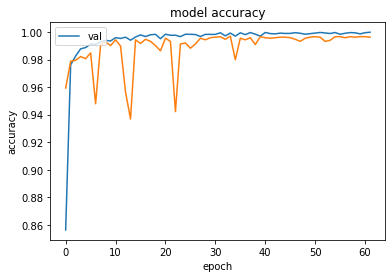

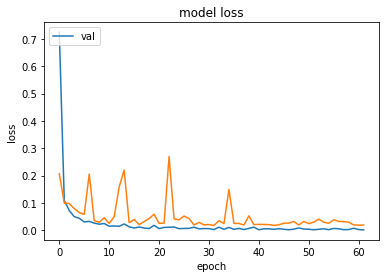

In [27]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [28]:
get_test_performance(model, X_test, test_label)

94/94 [==============================] - 1s 15ms/step - loss: 0.4954 - accuracy: 0.9502 - auc: 0.9837 - recall: 0.9495
Test loss:0.4953523874282837
Test accuracy:0.9501838684082031
Test Recall: 0.9495152235031128
Test AUC: 0.9837199449539185


dataset 4 identity

In [29]:
num_classes = 20
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(35373, 6, 128, 1) (3941, 6, 128, 1)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_7 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_21 (Conv1D)          (None, 128, 32)           1760      
                                                                 
 batch_normalization_21 (Bat  (None, 128, 32)          128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 128, 32)           0         
                                                                 
 conv1d_22 (Conv1D)          (None, 128, 512)          147968    
                      

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 6, 128)]          0         
                                                                 
 permute_8 (Permute)         (None, 128, 6)            0         
                                                                 
 conv1d_24 (Conv1D)          (None, 128, 32)           1760      
                                                                 
 batch_normalization_24 (Bat  (None, 128, 32)          128       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 128, 32)           0         
                                                                 
 conv1d_25 (Conv1D)          (None, 128, 512)          147968    
                                                           

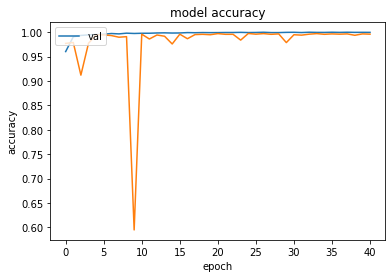

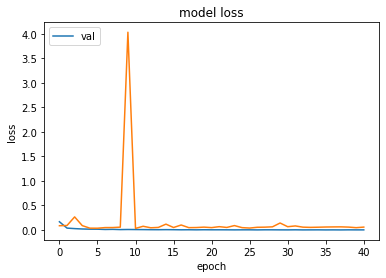

In [30]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [31]:
get_test_performance(model, X_test, test_label)

124/124 [==============================] - 2s 15ms/step - loss: 0.0917 - accuracy: 0.9843 - auc: 0.9960 - recall: 0.9810
Test loss:0.09174748510122299
Test accuracy:0.9842679500579834
Test Recall: 0.9809693098068237
Test AUC: 0.9959704279899597
